Define functional categories and filter calls for those in Control and SCZ individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import attila_utils
import funcvar
import functools
import ensembl_rest
import os.path
from bsmcalls import SNPnexus
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Preparations

In [2]:
D = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')

In [3]:
d = {'coding nonsyn': 'near_gens_Annotation', 'stop-gain': 'near_gens_Annotation', 'intronic (splice_site)': 'near_gens_Annotation'}
A = funcvar.count_members(D, d)
B = D.groupby('Dx')['sift_Prediction'].apply(pd.Series.value_counts).unstack().T.loc[['Deleterious', 'Deleterious - Low Confidence']]
counts = pd.concat([A, B], axis=0)
counts = counts.append(D.groupby('Dx')['tfbs_TFBS Name_bin'].sum().astype('int64'))
counts = counts.append(D.groupby('Dx')['regbuild_Epigenome_nervoussys_bin'].sum().astype('int64'))
counts = counts.append(D.groupby('Dx')['gerp_Element RS Score_bin'].sum().astype('int64'))
counts

Dx,ASD,Control,SCZ
coding nonsyn,23,23,44
stop-gain,1,2,4
intronic (splice_site),0,0,1
Deleterious,9,8,14
Deleterious - Low Confidence,2,1,3
tfbs_TFBS Name_bin,50,48,78
regbuild_Epigenome_nervoussys_bin,416,341,517
gerp_Element RS Score_bin,208,140,262


### GWAS genes

Here we take supplementary table 4 from the [CLOZUK paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5918692/) (clozapine UK), whose `Gene(s) tagged` column we turn into the `gwasgenes` set.

In [4]:
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = funcvar.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')
repr(gwasgenes)

"{'FAM57B', 'TMEM243', 'NAB2', 'AS3MT', 'PJA1', 'LINC00634', 'KCNV1', 'BRINP2', 'DDX28', 'THOC7', 'CMTR2', 'AKAP6', 'CLP1', 'UBE3D', 'MIR4655', 'LOC102546226', 'NLGN4X', 'UBE2Q2P2', 'HYDIN', 'ZDHHC5', 'INO80E', 'CNNM2', 'ALMS1-IT1', 'CHRM3', 'SDCCAG8', 'LOC101927273', 'CPT1C', 'GRIN2A', 'MIR6773', 'ENKD1', 'MMP16', 'CLU', 'NDFIP2', 'RABGAP1L', 'VPS13C', 'MSRA', 'LOC100505474', 'STAR', 'LINC00637', 'FXR1', 'KCNK7', 'STAT6', 'C4orf27', 'LOC388906', 'PTPRK', 'PLEKHO1', 'ZNF804A', 'GDPD3', 'RFT1', 'KCTD13', 'LOC283177', 'MEF2C', 'CREB3L1', 'FSHB', 'NDUFA6', 'EFHD1', 'ARHGAP1', 'PCGF6', 'GID4', 'XRCC3', 'BOLL', 'RFTN2', 'AIG1', 'EHBP1L1', 'CILP2', 'ATXN7', 'CTNND1', 'NT5C2', 'LOC100506472', 'MSANTD2', 'FAM109B', 'RLTPR', 'CSMD1', 'RPEL1', 'NDUFA13', 'CENPT', 'ANKRD44', 'CCDC175', 'LOC101928782', 'MIR5088', 'SNORA46', 'MSL2', 'TAOK2', 'MIR4677', 'MIR1284', 'BCL2L12', 'RAI1', 'HSPE1', 'EPHX2', 'CACNA1C', 'GOLGA6L17P', 'EPN2-AS1', 'FGFR1', 'ZNF536', 'SEPT3', 'COQ10B', 'SETD8', 'SLC39A8', 'NEK1

In [5]:
Dgwas = D.loc[D['near_gens_Overlapped Gene'].apply(lambda x: bool(set(x).intersection(gwasgenes))), :]
counts_gwas = funcvar.all_functional_counts(Dgwas)
counts_gwas

Dx,ASD,Control,SCZ
coding nonsyn,0,1,0
stop-gain,0,0,0
intronic (splice_site),0,0,0
Deleterious,0,0,0
Deleterious - Low Confidence,0,0,0
tfbs_TFBS Name_bin,1,1,2
regbuild_Epigenome_nervoussys_bin,6,6,13
gerp_Element RS Score_bin,6,3,9


### DeepSEA score
[DeepSEA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/) predicts effects of noncoding variants with deep learning–based sequence model.

['named-figure/deepsea-hist.png', 'named-figure/deepsea-hist.pdf']

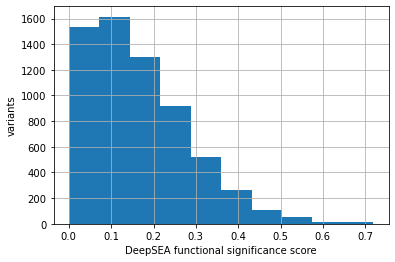

In [6]:
fig, ax = plt.subplots()
D['deepsea_Functional Significance Score'].hist(ax=ax)
ax.set_xlabel('DeepSEA functional significance score')
ax.set_ylabel('variants')
attila_utils.savefig(fig, 'deepsea-hist')

The histogram suggests a cutoff somewhere between 0.5 and 0.6 score.  I will define functionally significant variants using both a more lenient and a more stringent threshold.

### Loss of function variants

These include stop-gain, intronic (splice_site), and frameshift.  Note that we didn't observe any frameshift variants.  These might be the most revealing.

In [7]:
cols = ['Dataset', 'Dx', 'near_gens_Annotation', 'near_gens_Overlapped Gene']
LoFrows = D['near_gens_Annotation'].apply(lambda x: bool(set(x).intersection({'stop-gain', 'intronic (splice_site)'})))
D.loc[LoFrows, cols]

Dataset       Dx  \
Individual ID CHROM          POS      Mutation                     
CMC_MSSM_299  14             24731243 G/A        Chess   SCZ       
CMC_MSSM_340  12             52445358 T/G        Chess   SCZ       
              22             38352865 C/T        Chess   SCZ       
CMC_MSSM_343  1              28099835 T/G        Chess   SCZ       
CMC_PITT_052  7              30961738 C/T        Chess   SCZ       
UMB1465       frontal cortex 4        154649455  Walsh   Control   
UMB1474       frontal cortex 14       60451886   Walsh   Control   
UMB1638       frontal cortex 2        179612387  Walsh   ASD       

                                                                                                                                   near_gens_Annotation  \
Individual ID CHROM          POS      Mutation                                                                                                            
CMC_MSSM_299  14             24731243 G/A        [5upstream, intronic, coding *nonsyn, stop-gain, 3downstream, coding nonsyn, stop-gain]                  
CMC_MSSM_340  12             52445358 T/G        [5upstream, non-coding intronic, intronic, intronic (splice_site)]                                       
              22             38352865 C/T        [non-coding intronic, intronic, coding nonsyn, stop-gain]                                                
CMC_MSSM_343  1              28099835 T/G        [coding nonsyn, stop-gain, non-coding, coding *nonsyn, stop-gain]                                        
CMC_PITT_052  7              30961738 C/T        [non-coding, coding nonsyn, stop-gain]                                                                   
UMB1465       frontal cortex 4        154649455  [coding nonsyn, stop-gain, coding *nonsyn, stop-gain, intronic, non-coding, 3utr, non-coding intronic]   
UMB1474       frontal cortex 14       60451886   [coding nonsyn, stop-gain, non-coding intronic]                                                          
UMB1638       frontal cortex 2        179612387  [non-coding intronic, coding nonsyn, stop-gain, intronic]                                                

                                                near_gens_Overlapped Gene  
Individual ID CHROM          POS      Mutation                             
CMC_MSSM_299  14             24731243 G/A        [TGM1]                    
CMC_MSSM_340  12             52445358 T/G        [NR4A1]                   
              22             38352865 C/T        [POLR2F]                  
CMC_MSSM_343  1              28099835 T/G        [STX12]                   
CMC_PITT_052  7              30961738 C/T        [AQP1]                    
UMB1465       frontal cortex 4        154649455  [RNF175]                  
UMB1474       frontal cortex 14       60451886   [LRRC9, RP11-16B13.1]     
UMB1638       frontal cortex 2        179612387  [TTN-AS1, TTN]

### Functional variants

First let's see Taejeong's definition of functional variants

> The terms that we chose as functional are missense, stop_gained, splice_region, regulatory, and TF_binding.

### Outlier individual

In [10]:
# TODO
#D.loc[funcAby, sel_cols].loc['CMC_MSSM_224']

In [11]:
%connect_info

{
  "shell_port": 42867,
  "iopub_port": 54495,
  "stdin_port": 42499,
  "control_port": 59341,
  "hb_port": 47625,
  "ip": "127.0.0.1",
  "key": "7eabf9d2-a31bada40f91c8a153f469ae",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-055dfbf2-b1d9-4e69-a24a-5a40449660e3.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
